# Nicholas Tam Final Visualization

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystem?

Given the research question, it would be ideal to analyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species.

The following questions will be used as guidelines to supplement the question:
- What are the numbers and proportions of planted trees, by species and genus?
- Which locations within each neighbourhood can host wide varieties of species?
- How do trees that have been planted directly compare in terms of diameter and height to those that have grown naturally?

## Subquestion of interest: How do trees that have been planted directly compare in terms of diameter and height to those that have grown naturally?

In [1]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

import sys
sys.path.append("../../code")
sys.path.append("../../images")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image
import geopandas as gpd
import json

In [2]:
# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

# Set up file path to save images
viz_folder = '../../images/ntam_viz/'

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Processed Data
- Upon loading `public_trees_cleaned.csv`, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.
- `public_trees_planted` is created to filter for species with existing planted trees.

In [3]:
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


In [4]:
planted_species = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull(), 'SPECIES_NAME'].unique()
public_trees_planted = public_trees_cleaned[public_trees_cleaned['SPECIES_NAME'].isin(planted_species)]

## Visualization 3: How do trees that have been planted directly compare in terms of diameter to those that have grown naturally?

### Marks
- Histogram:  
  - Used to display percentage changes in height between planted and non-planted specimens among all species.  
  - Bar heights correspond to counts for each range of change in height, allowing for a display on the distribution of potential height changes.  
  - Since the dataset only provides height ranges for each specimen, the heights for the trees had to be estimated by using the averages for each range, with the `>90` category being estimated with 100 m.

- Dot plot:  
  - Used to display the percentage changes in diameter between planted and non-planted specimens across all species.  
  - Dot positions represent percentage changes between planted and non-planted specimens across species, and the species are set in descending order. 
  - Used over bar charts to follow Tufte’s principle of data-ink ratio.

### Channels
- Histogram  
  - Position: 
    - X-axis represents bins of percentages to organise data into discrete categories.
    - Y-axis represents counts of species, showing magnitude. 
  - Length: Bar lengths encode the number of species in each height range, simplifying comparisons.  
  - Tooltip: Provides specific count value for hovered histogram bins, allowing for more direct comparison of values.  

- Dot plot
  - Position:  
    - X-axis represents species, in descending order of percentage values.
    - Y-axis represents percentage changes in percentage changes in diameter between planted and non-planted specimens, allowing for an accurate display of the variation in differences across species.
  - Color: Color selected for each point is dependent on whether the value is negative or positive, with the specific color scheme selected to account for colorblindness. 
  - Tooltip: Displays the corresponding values for each species displayed, such as genus and percentage change in height, improving clarity.  


### Interaction and UI Widgets
- Genus Dropdown:  
  - Filters trees based on genus, dynamically updating both the histogram and dot plot. 
  - This ensures the user can apply focused comparisons of physical properties between similar species.  

- Linked Filtering:  
  - The user can brush the histogram to filter out which species had the corresponding change in height to be displayed in the dot plot along with their corresponding change in diameter.

- Conditional Highlighting:  
  - Brushing the histogram changes the corresponding counts for each blue bar, while the grey bars behind them display the original distribution.

- Tooltip Enhancements:  
  - Tooltips provide precise numerical values for counts and the percentage changes corresponding to each species, enhancing interpretability without cluttering the visualization. 

### Tasks Supported by the Visualization
- Retrieve Value: Tooltips allow users to extract specific details, such as counts in specific ranges and percentage changes for species.  
- Filter: Users can filter data by genus (via dropdown) and by brushing in histogram, enabling focused exploration.  
- Compute Derived Value: Differences in height and diameter between planted and non-planted trees are obtained by calculating the average height and diameter for each species, then comparing the percentage change from non-planted trees to planted trees. Since the dataset only provides height ranges for each specimen, the heights for the trees had to be estimated by using the averages for each range, with the `>90` category being estimated with 100 m.
- Sort: Neighborhoods are implicitly ranked by tall tree counts (via color intensity on the map), and height ranges are sorted by tree count in the bar chart.  
- Characterize Distribution: The combination of the historgam and dot plot allows users to analyze the distribution of changes in height and diameter.  

### Why These Choices Were Effective
1. Comprehensive Analysis:  
   - The histogram provides an overview of the distribution of height changes.  
   - The dot plot displays the changes in diameter changes across species.  
   - These combined provide a better understanding of how drastically certain planted trees may differ compared to their naturally grown counterparts. 

2. Dynamic Exploration:  
   - The dropdown menu and histogram brush allow users to explore the data dynamically, refining their analysis based on genus and height range.  
   - Linked filtering ensures consistency between the histogram and dot plot, maintaining a seamless exploration experience.  

3. Enhanced Interpretability:  
   - Conditional highlighting and tooltips improve clarity, making it easier for users to interpret the data and make informed decisions about identifying plants that grow differently from their naturally-grown counterparts.  

### Further developments 
- The displayed data is limited by the inability to ensure that there are sufficient planted and non-planted samples for each given species. Thus the calculated differences in diameter and height may be highly skewed and otherwise inaccurate, and will need to be accounted for in the future.
- Similarly, any species that does not have sufficient data needs to be shown as well in some form.

In [5]:
# https://pages.github.ubc.ca/firasm/DSCI320-2024W2/notes/tutorials/12_Interaction.html#details-on-demand

# Diameter range in histogram
brush_hist = alt.selection_interval(encodings=['x'], name="brushHist")

# Point for which to provide details-on-demand
label = alt.selection_point(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty=False     # empty selection includes no data points
)

# Dropdown family
list_genus = public_trees_planted['GENUS_NAME'].unique().tolist()
dropdown_genus = alt.binding_select(options=[None] + list_genus, name='Genus: ', labels = ['All'] + list_genus)
selection_genus = alt.selection_point(fields=['GENUS_NAME'], bind=dropdown_genus)
predicate_genus = (selection_genus | (alt.datum.GENUS_NAME == None))

# Estimation of height differences
height_dict = {
    '10-20':15, '20-30':25, '30-40':35, '40-50':45, '50-60':55, '60-70':65, '70-80':75, '80-90':85, '>90':100
}
public_trees_planted['HEIGHT_MEANS'] = public_trees_planted['HEIGHT_RANGE'].astype(str).map(height_dict)

# Calculate the percentage change of diameter and height for each species, grouped by whether they are planted or not
species_diffs = public_trees_planted.groupby('SPECIES_NAME').agg(
    GENUS_NAME=('GENUS_NAME', 'first'),
    Diameter_Plant=('DIAMETER', lambda x: x[public_trees_planted['DATE_PLANTED'].notna()].mean()), 
    Diameter_Not_Plant=('DIAMETER', lambda x: x[public_trees_planted['DATE_PLANTED'].isna()].mean()),
    Height_Plant=('HEIGHT_MEANS', lambda x: x[public_trees_planted['DATE_PLANTED'].notna()].mean()), 
    Height_Not_Plant=('HEIGHT_MEANS', lambda x: x[public_trees_planted['DATE_PLANTED'].isna()].mean())
).reset_index()

species_diffs['Percent_Diff_D'] = ((species_diffs['Diameter_Plant'] - species_diffs['Diameter_Not_Plant']) / species_diffs['Diameter_Not_Plant']) * 100
species_diffs['Percent_Diff_H'] = ((species_diffs['Height_Plant'] - species_diffs['Height_Not_Plant']) / species_diffs['Height_Not_Plant']) * 100

# Histogram for heights
hist_base = (
    alt.Chart(species_diffs)
    .mark_bar()
    .encode(
        alt.X('Percent_Diff_H:Q', title="Percentage Change in Height (%)", bin=alt.BinParams(maxbins=20)),
        alt.Y('count():Q'),
        # color=alt.condition(brush_hist, alt.value("#1f77b4"), alt.value("lightgray")),
        # opacity=alt.condition(brush_hist, alt.value(0.9), alt.value(0.2)),
        tooltip=[
            # alt.Tooltip("Percent_Diff_H:Q", title="Change in Average Height (%)"),
            alt.Tooltip("count():Q", title="Count for bin"),
        ]
    )
    .add_params(selection_genus, brush_hist)  # Allow selection on histogram
    .transform_filter(predicate_genus) 
    .properties(
        title="Tree Height by Planted Status",
    )
)

# For selection in histogram
hist_diam = alt.layer(
    hist_base.add_params(brush_hist).encode(color=alt.value('lightgrey')),
    hist_base.transform_filter(brush_hist)
)

# Dot plot of heights against species, in descending order of percentage change
points_base = (
    alt.Chart(species_diffs.dropna()).mark_point(filled=True, size=100).transform_calculate(
        Diff_Category="datum.Percent_Diff_D >= 0 ? 'Positive' : 'Negative'"  # Categorizing increases vs. decreases
    ).encode(
        alt.X('SPECIES_NAME:N', title="Species", sort='-y'),
        alt.Y('Percent_Diff_D:Q', title="Percentage Change in Diameter (%)"),
        alt.Color(
            'Diff_Category:N', 
            scale=alt.Scale(domain=['Positive', 'Negative'], range=['#005AB5', '#DC3220']),  # Blue for increase, Red for decrease
            title="Diameter Change", 
            # legend=alt.Legend(orient="left"),
        ),
        # opacity=alt.condition(brush_hist, alt.value(0.8), alt.value(0.2)),
        tooltip=[
            alt.Tooltip("SPECIES_NAME:N", title="Species"),
            alt.Tooltip("GENUS_NAME:N", title="Genus"),
            alt.Tooltip("Percent_Diff_D:Q", title="Change in Diameter (%)"),
            alt.Tooltip("Percent_Diff_H:Q", title="Change in Average Height (%)"),
        ]
    )
    .add_params(selection_genus)  # Allow selection on scatter plot
    .transform_filter(brush_hist & predicate_genus)  
    .properties(
        title="Tree Diameter Change by Species",
    )
)

points = alt.layer(
    points_base.add_params(label), 
    
    # # add a rule mark to serve as a guide line
    # alt.Chart().mark_rule(color='#bbb').encode(
    #     alt.X('SPECIES_NAME:N', title="Species", sort='-y'),
    #     alt.Y('Percent_Diff_D:Q', title="Percentage Change in Diameter (%)"), # Want to modify to go through entirely anyway
    # ).transform_filter(label),
    
    # # # add circle marks for selected time points, hide unselected points
    # # base.mark_circle().encode(
    # #     opacity=alt.condition(label, alt.value(1), alt.value(0))
    # # ),

    # # add white stroked text to provide a legible background for labels
    # points_base.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
    #     text='Percent_Diff_D:Q'
    # ).transform_filter(label),

    # # add text labels for percentage differences
    # points_base.mark_text(align='left', dx=5, dy=-5).encode(
    #     text='Percent_Diff_D:Q'
    # ).transform_filter(label),
    
    # data=species_diffs
)

/var/folders/sp/136d3tf94ns_hpp_7z4mgphm0000gp/T/ipykernel_12419/1687232212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_trees_planted['HEIGHT_MEANS'] = public_trees_planted['HEIGHT_RANGE'].astype(str).map(height_dict)


/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

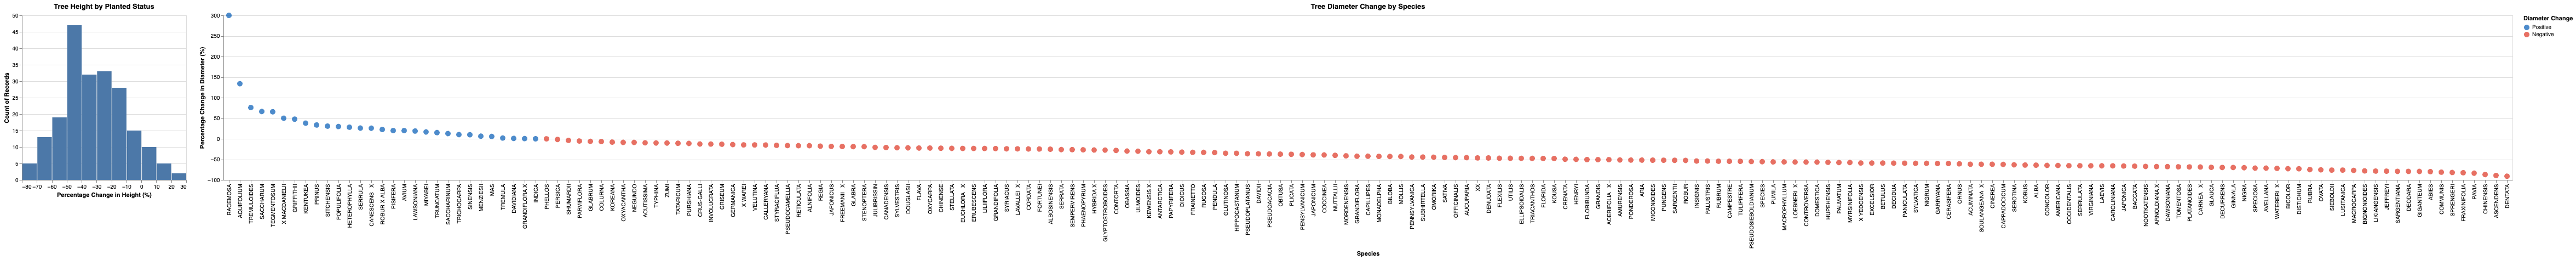

In [6]:
# Combine Histogram and Scatter Plot Side by Side
viz3 = hist_diam | points
viz3.save(viz_folder+'plant_viz3.png')
viz3.save(viz_folder+'plant_viz3.html')
viz3